In [15]:
import pandas as pd
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import zipfile
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import random
import numpy as np
import time as t

## Extract images from zip file

In [2]:
# Path to the ZIP file
zip_file_path = "qr_images.zip"

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("qr_images_extracted")

# List all files in the extracted folder
extracted_files = os.listdir("qr_images_extracted/content/qr_images")

# Filter out files with the desired format
matching_files = [filename for filename in extracted_files if filename.startswith("qr_code_") and filename.endswith(".png")]

# Check how many images there are and if all have the desired format
total_images = len(extracted_files)
matching_format = len(matching_files) == total_images

print(f"Total number of images: {total_images}")
print(f"All images have the desired format: {matching_format}")


Total number of images: 11430
All images have the desired format: True


Check if there are any duplicates.

In [48]:
duplicate_files_indices = {}

# Iterate through the list of filenames
for index, filename in enumerate(extracted_files):
    # If the filename already exists in the dictionary, add the current index to the list of indices
    if filename in duplicate_files_indices:
        duplicate_files_indices[filename].append(index)
    else:
        # If the filename is encountered for the first time, initialize a list with the current index
        duplicate_files_indices[filename] = [index]
# Filter out filenames with more than one index (indicating duplicates)
duplicate_filenames = {filename: indices for filename, indices in duplicate_files_indices.items() if len(indices) > 1}

# Print the indices of files with the same name
if duplicate_filenames:
    print("Files with the same name:")
    for filename, indices in duplicate_filenames.items():
        print(f"Filename: {filename}, Indices: {indices}")
else:
    print("No files with the same name.")

No files with the same name.


## Preprocessing of the images for the CNN

In [3]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, labels, transform=None):
        self.data_dir = data_dir
        self.labels = labels
        self.transform = transform
        self.image_paths = [os.path.join(data_dir, f"qr_code_{idx}.png") for idx in range(len(labels))]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, f"qr_code_{idx}.png")  # Assuming image filenames are indexed
        image = datasets.folder.default_loader(img_name)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


### Convert the images to Pytorch tensors and split the data

In [4]:
# Define the path to the folder containing images
data_dir = "qr_images_extracted/content/qr_images/"
#/content/qr_images_extracted/content/qr_images/qr_code_0.png
# Load your data to extract target
df = pd.read_csv("df_lexical_unscaled.csv")

# Extract labels from the 'target' column
labels = df.iloc[:, -1].tolist()

# Define transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size (you can adjust this)
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])

# Create the custom dataset
custom_dataset = CustomDataset(data_dir, labels, transform=transform)

# Split the dataset into train and test sets
train_size = int(0.8 * len(custom_dataset))  # 80% of the data for training
train_train_size = int(0.8 * train_size)
train_validation_size =train_size -train_train_size
test_size = len(custom_dataset) - train_size  # Remaining 20% for testing

train_set, test_set = torch.utils.data.random_split(custom_dataset, [train_size, test_size])
train_train, train_val = torch.utils.data.random_split(train_set, [train_train_size, train_validation_size])

# Create data loaders for train and test sets
#train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

# Update the creation of train_loader and test_loader
train_loader = torch.utils.data.DataLoader(train_set.dataset, batch_size=32, shuffle=True)
train_train_loader = torch.utils.data.DataLoader(train_train.dataset, batch_size=32, shuffle=True)
train_val_loader = torch.utils.data.DataLoader(train_train.dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set.dataset, batch_size=32, shuffle=False)


In [5]:
traindata = iter(train_loader)

images, labels = next(traindata)

print(images[1].shape)

torch.Size([1, 224, 224])


In [41]:
import copy
print(f'The number of qr codes in the train set is :{len(train_loader.dataset)}, therefore we will take {0.8*len(train_loader.dataset)} images for training and the rest of them for validate')
valid_loader = copy.deepcopy(train_loader)  # Creates a copy of the object



The number of qr codes in the train set is :11430, therefore we will take 9144.0 images for training and the rest of them for validate


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 classes: legitimate or phishing

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
model = SimpleCNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [17]:
# Set seed for Python random module
random_seed = 123
random.seed(random_seed)

# Set seed for NumPy
np.random.seed(random_seed)

# Set seed for PyTorch
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Initialize lists to store loss and accuracy values
train_losses = []
val_losses = []
accuracies = []

# Define number of epochs
num_epochs = 10

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print('The CPCU is available')
model.to(device)

start = t.time()
# Training loop
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    running_loss = 0.0
    for images, labels in train_train_loader:
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * images.size(0)

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_train_loader.dataset)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")
    train_losses.append(epoch_loss)

    end = t.time()
    training_time = end-start
    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in train_val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average validation loss
    val_loss /= len(train_val_loader.dataset)

    # Calculate accuracy
    accuracy = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")


    # Append loss and accuracy values to lists
    val_losses.append(val_loss)
    accuracies.append(accuracy)
print("Training finished.")



The CPCU is available
Epoch [1/10], Train Loss: 0.6704
Epoch [1/10], Validation Loss: 0.6216, Accuracy: 0.6180
Epoch [2/10], Train Loss: 0.6100
Epoch [2/10], Validation Loss: 0.5592, Accuracy: 0.7123
Epoch [3/10], Train Loss: 0.5354
Epoch [3/10], Validation Loss: 0.4980, Accuracy: 0.7663
Epoch [4/10], Train Loss: 0.4728
Epoch [4/10], Validation Loss: 0.4113, Accuracy: 0.8177
Epoch [5/10], Train Loss: 0.4181
Epoch [5/10], Validation Loss: 0.3633, Accuracy: 0.8397
Epoch [6/10], Train Loss: 0.3575
Epoch [6/10], Validation Loss: 0.2848, Accuracy: 0.8741
Epoch [7/10], Train Loss: 0.2833
Epoch [7/10], Validation Loss: 0.2032, Accuracy: 0.9151
Epoch [8/10], Train Loss: 0.2099
Epoch [8/10], Validation Loss: 0.1289, Accuracy: 0.9555
Epoch [9/10], Train Loss: 0.1446
Epoch [9/10], Validation Loss: 0.1109, Accuracy: 0.9651
Epoch [10/10], Train Loss: 0.0987
Epoch [10/10], Validation Loss: 0.0764, Accuracy: 0.9752
Training finished.


In [25]:
print('Training execution time',round(training_time,2), 'seconds, so',round(training_time/60, 2) ,'minutes.')


Training execution time 654.62 seconds, so 10.91 minutes.


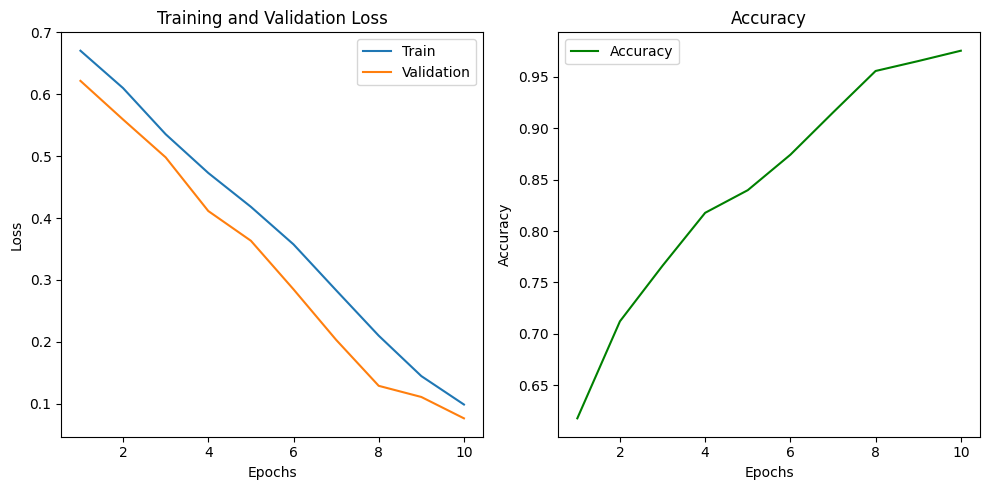

In [26]:
# Plotting
plt.figure(figsize=(10, 5))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracies, label='Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# Set model to evaluation mode
model.eval()

# Initialize variables for accuracy calculation
correct = 0
total = 0

# Initialize lists to store predictions and ground truth labels
all_predictions = []
all_labels = []

# Disable gradient computation for inference
with torch.no_grad():
    for images, labels in test_loader:
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get predictions
        _, predicted = torch.max(outputs.data, 1)

        # Update total count of samples
        total += labels.size(0)

        # Update count of correct predictions
        correct += (predicted == labels).sum().item()

        # Store predictions and ground truth labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9229


In [30]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate precision, recall, and F1-score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f"Accuracy:{accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")


Accuracy:0.9229, Precision: 0.9237, Recall: 0.9229, F1-score: 0.9229
